# MLP from scratch
Here we have implemented a Multilayer Perceptron Neural Network. Our implementation enables us to create networks that accept inputs and outputs of various lengths. Also, it could contain a different number of hidden layers with varying activation functions.

## Layer Implementation
Two main parts of each layer's computation are forward and backward computations. Forward one is for calculating the output of the layer based on its input and parameters. The backward method is for updating the parameters based on the layer's input, output, and expected output. The backward function updates the layer's parameters based on the error of the output.

In [32]:
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Normalizer
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

class Layer:
	def __init__(self, shape, activation_function='ReLU', is_output_layer=False):
		self.shape = shape
		self.weights = np.random.normal(size=self.shape)
		self.biases = np.zeros(self.shape[1])
		self.activation_function = activation_function
		self.is_output_layer = is_output_layer

	def forward(self, input_):
		self.input = input_
		self.output = self.activate(np.dot(input_, self.weights) + self.biases)
		return self.output

	def backward(self, learning_rate, y):
		if self.is_output_layer:
			E = self.output - y
		else:
			E = y
		
		d_output = E * self.derivative_activate(self.output)
		
		grad_weights = np.dot(self.input.T, d_output)
		grad_biases = np.sum(d_output, axis=0)
		
		self.weights = self.weights - learning_rate * grad_weights
		self.biases = self.biases - learning_rate * grad_biases

		return np.dot(d_output, self.weights.T)

	def activate(self, input_):
		if self.activation_function == 'ReLU':
			return np.maximum(0, input_)
		elif self.activation_function == 'sigmoid':
			return 1./(1.+np.exp(-input_))
		elif self.activation_function == 'tanh':
			return np.tanh(input_)
		else:
			raise 'activation function not defined'

	def derivative_activate(self, input_):
		if self.activation_function == 'ReLU':
			return (input_ > 0) * 1
		elif self.activation_function == 'sigmoid':
			return self.activate(input_) * (1-self.activate(input_))
		elif self.activation_function == 'tanh':
			return 1/(np.cosh(input_)**2)
		else:
			raise 'activation function not defined'


In [33]:

class Model:
	def __init__(self, layers=[]):
		self.network = []
		if layers:
			for shape in layers[:-1]:
				self.add_layer(shape, activation_function='ReLU')
			self.add_layer(layers[-1], activation_function='sigmoid',
			               is_output_layer=True)

	def add_layer(self, shape, activation_function='ReLU', is_output_layer=False):
		self.network.append(Layer(shape, activation_function, is_output_layer))

	def forward(self, input_):
		for layer in self.network:
			input_ = layer.forward(input_)
		return input_

	def backward(self, learning_rate, expected_output):
		for layer in reversed(self.network):
			expected_output = layer.backward(learning_rate, expected_output)

		return expected_output

	def fit(self, input_, output, n_epoch, learning_rate):
		for epoch in range(n_epoch):
			if epoch % 100 == 0 or epoch == n_epoch - 1:
				print("epoch:", str(epoch + 1) + '/' + str(n_epoch))
			self.forward(input_)
			self.backward(learning_rate, output)

	def predict(self, X, Y, show_function=None):
		Y_pred = self.forward(X).argmax(1)
		score = 0
		
		for y, y_pred in zip(Y, Y_pred):
			if abs(y - y_pred) <= 0.5:
				score += 1
		
		if show_function is not None:
			show_function(X, Y, Y_pred)
	
		return score/len(X)

	def __str__(self):
		result = "***************\n"
		for layer in self.network:
			result += str(layer.shape) + ':\t' + layer.activation_function + '\n'
			result += "***************\n"
		return result


In [34]:
def show_function(X, Y, Y_pred):
	true_ones = []
	true_zeros = []
	false_ones = []
	false_zeros = []
	
	for x, y, y_pred in zip(X, Y, Y_pred):
		if y:
			if y_pred:
				true_ones.append(x)
			else:
				false_zeros.append(x)
		else:
			if y_pred:
				false_ones.append(x)
			else:
				true_zeros.append(x)
	
	true_ones = np.reshape(true_ones, [len(true_ones), 2])
	true_zeros = np.reshape(true_zeros, [len(true_zeros), 2])
	false_ones = np.reshape(false_ones, [len(false_ones), 2])
	false_zeros = np.reshape(false_zeros, [len(false_zeros), 2])

	plt.scatter(true_ones[:, 0], true_ones[:, 1], color='darkgreen')
	plt.scatter(true_zeros[:, 0], true_zeros[:, 1], color='lightgreen')
	plt.scatter(false_ones[:, 0], false_ones[:, 1], color='darkred')
	plt.scatter(false_zeros[:, 0], false_zeros[:, 1], color='lightcoral')
	


## Test
Here we have loaded our train and test dataset. Due to the small size of our dataset, there was no need for mini-batches. Also, I tried several pre-processing methods, but none of them improved my accuracy. Noe that I have transformed my output to one-hot encoding.

In [35]:
train = np.loadtxt('dataset/train')
test = np.loadtxt('dataset/test')

train_X = train[:, :-1]
train_y = np.reshape(train[:, -1], (len(train), 1))
train_y_onehot = np.array([[0, 1] if x else [1, 0] for x in train_y])

test_X = test[:, :-1]
test_y = np.reshape(test[:, -1], (len(test), 1))
test_y_onehot = np.array([[0, 1] if x else [1, 0] for x in test_y])


# transformer = MinMaxScaler()
# transformer = Normalizer()

# train_X = transformer.fit_transform(train_X)
# test_X = transformer.transform(test_X)


For this test case, I used a model with three hidden layers of size 8 with the `ReLU` activation function. My output has a `sigmoid` activation function.

epoch: 1/1000
epoch: 101/1000
epoch: 201/1000
epoch: 301/1000
epoch: 401/1000
epoch: 501/1000
epoch: 601/1000
epoch: 701/1000
epoch: 801/1000
epoch: 901/1000
epoch: 1000/1000
accuracy train: 0.9245
accuracy test: 0.943


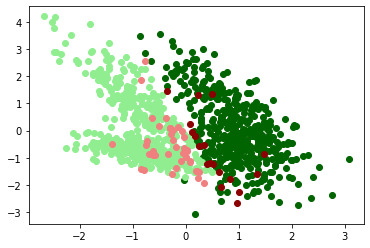

In [36]:
np.random.seed(42)
model = Model()
model.add_layer((2, 8), activation_function='ReLU')
model.add_layer((8, 8), activation_function='ReLU')
model.add_layer((8, 8), activation_function='ReLU')
model.add_layer((8, 2), activation_function='sigmoid', is_output_layer=True)
learning_rate = 0.00009
n_epoch = 1000

model.fit(train_X, train_y_onehot, n_epoch, learning_rate)
print('accuracy train:', model.predict(train_X, train_y))
print('accuracy test:', model.predict(test_X, test_y, show_function))


